In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from model import ResNet20
from Train import model_training
from quantization_encoder import Quant
from quantization_decoding import Quant_decode

In [2]:
# Hyper parameters
epoch_losses = []
train_loss_list = []
epochs = 200
train_batch_size = 256
test_batch_size = 128

# Model device assignment
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet20().to(device)

In [3]:
# Define transformation
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4), 
    transforms.RandomHorizontalFlip(),      
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                        (0.2023, 0.1994, 0.2010))
])

# Test transform (no augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                        (0.2023, 0.1994, 0.2010))
])

# Load the training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size,
                                          shuffle=True, num_workers=8)

# Load the test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                         shuffle=False, num_workers=0)

# Define the class names for reference
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

/usr/local/python/3.12.1/lib/python3.12/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [4]:
"""
# Training model on Cifar10
train_module = model_training(model, trainloader, epochs)
train_loss = train_module.forward(device)
"""

'\n# Training model on Cifar10\ntrain_module = model_training(model, trainloader, epochs)\ntrain_loss = train_module.forward(device)\n'

In [5]:
# Visualization of training results 
plt.plot(train_loss, linewidth=2, c='r')
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss of ResNet20 Model")
plt.grid(True)

plt.tight_layout()
plt.show()

NameError: name 'train_loss' is not defined

In [ ]:
model.eval()
with torch.no_grad():
    number_correct = 0
    samples = 0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, prediction = torch.max(outputs, 1)
        samples += labels.size(0)
        number_correct += (prediction == labels).sum().item()

accuracy = (number_correct / samples) * 100.0
print(f"Accuracy: {accuracy:.2f}")

In [ ]:
"""
torch.save(model.state_dict(), 'ResNet20_model.pth')
print("Model saved as 'ResNet20_model.pth'")
"""

In [6]:
# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_state_dict = torch.load('ResNet20_model.pth', map_location=device)

# Get all parameters
params = list(model_state_dict.items())
n_params = len(params)

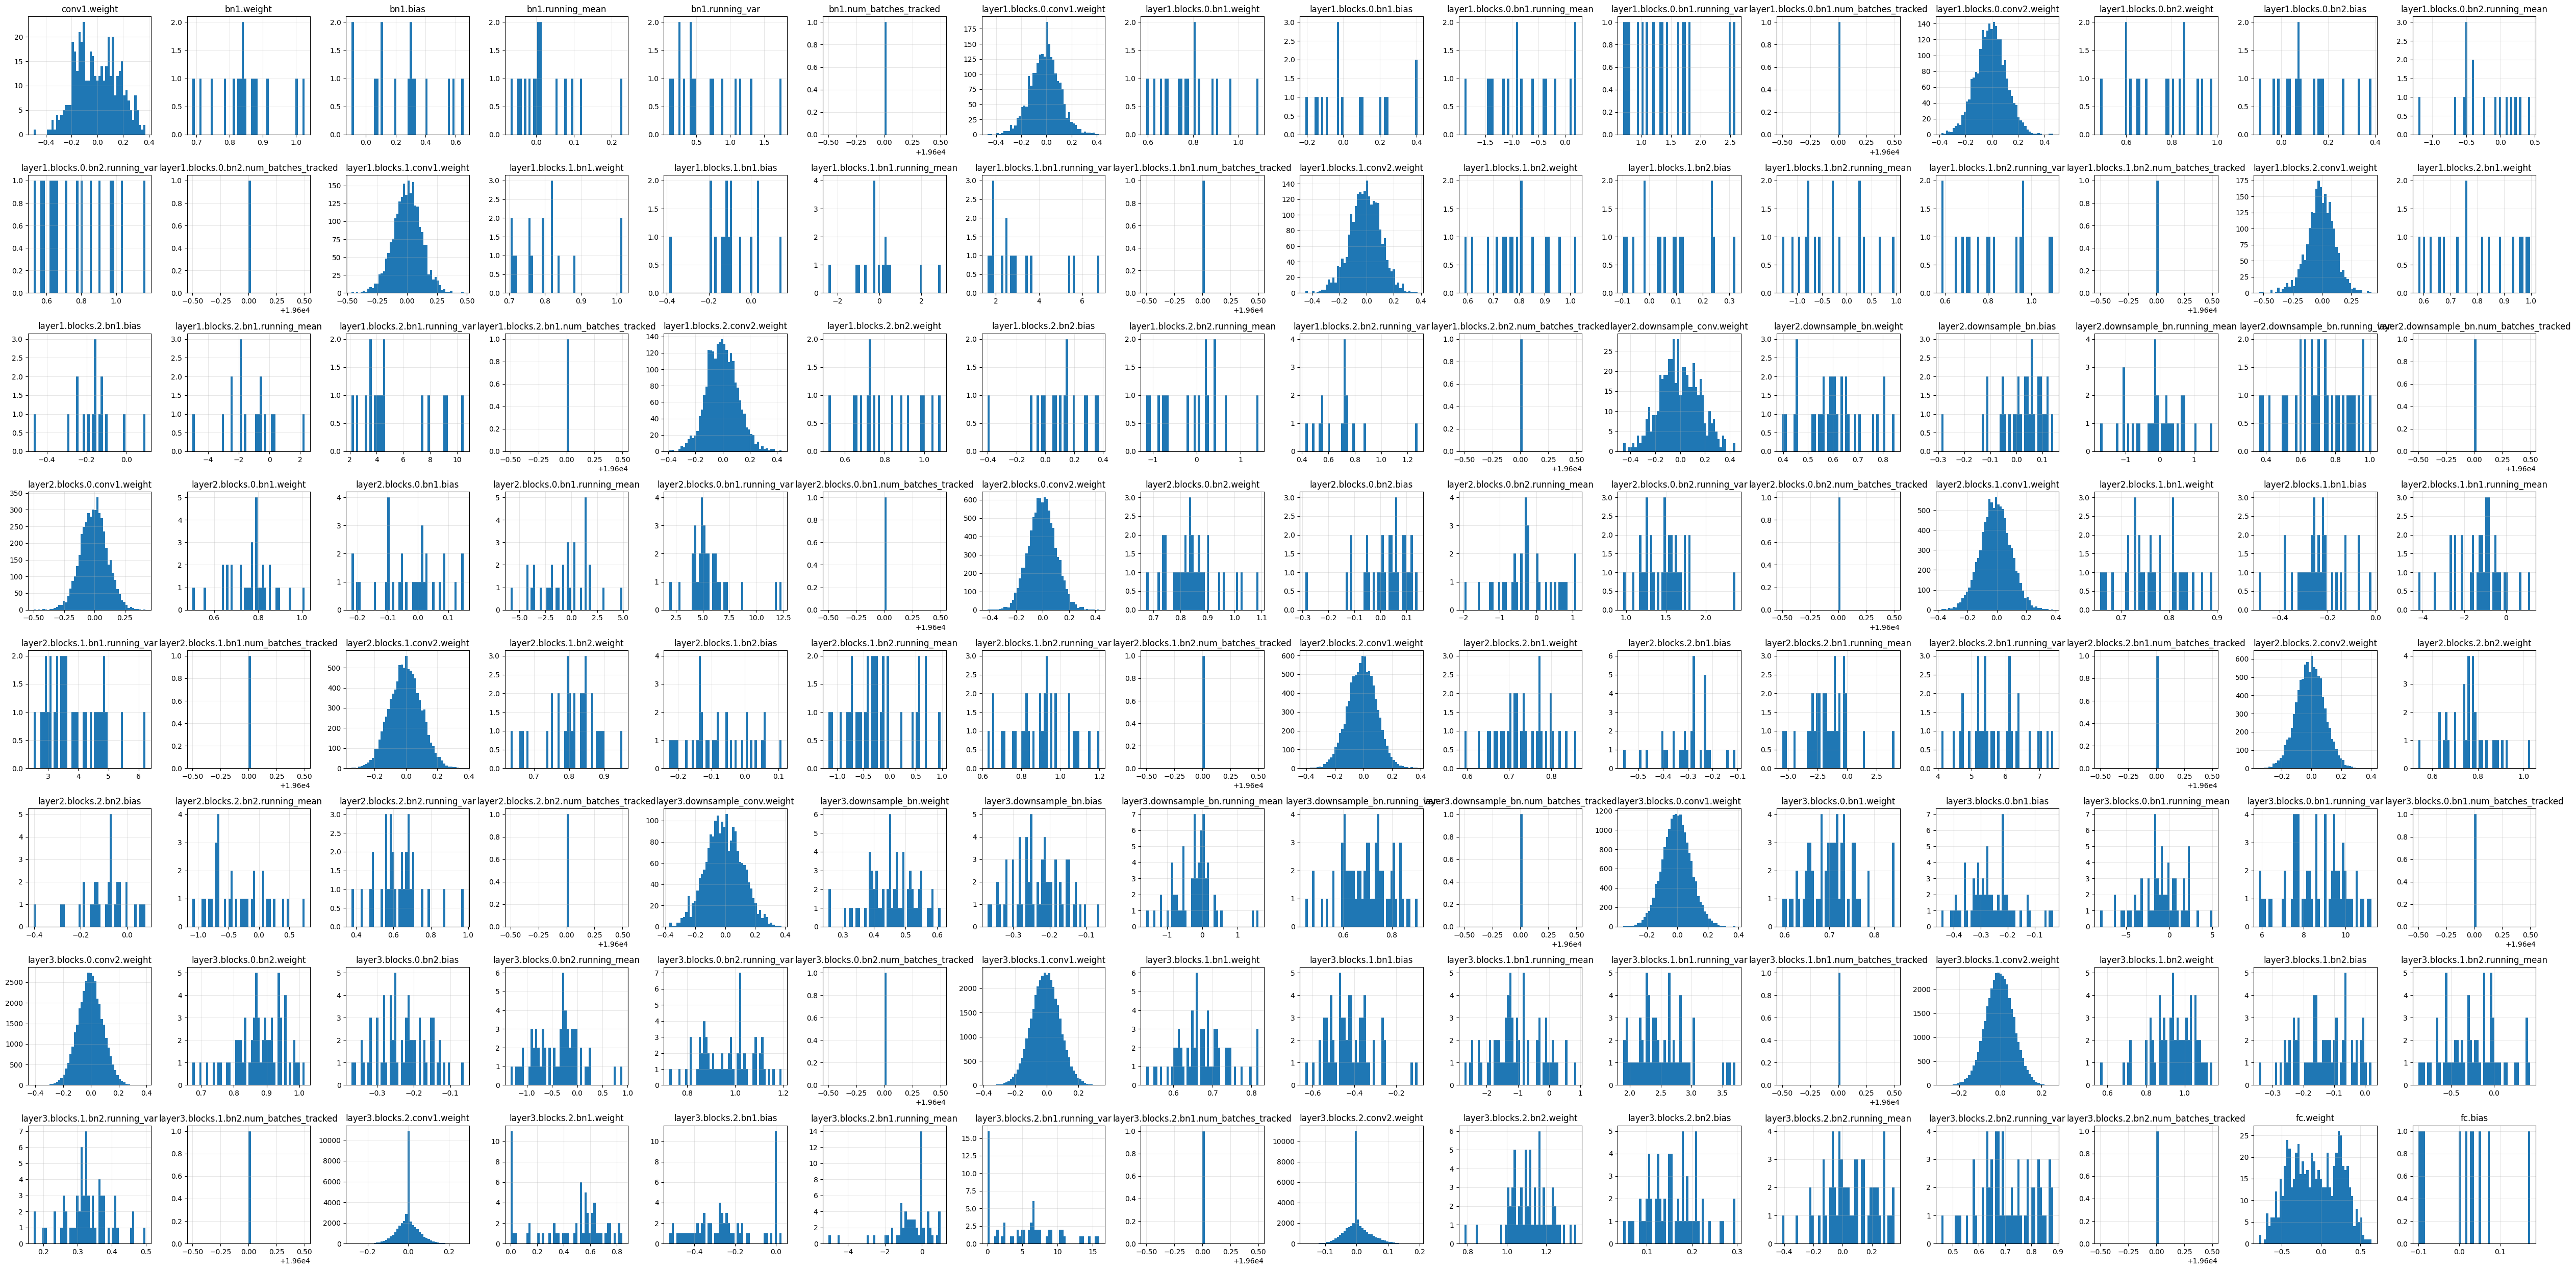

In [7]:
n_cols = 16  # 16 columns
n_rows = (n_params + n_cols - 1) // n_cols  # 8 rows for 128 params

# Create subplots with larger figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(50, 25))
axes = axes.flatten()

# Plot each parameter
for i, (name, tensor) in enumerate(params):
    values = tensor.cpu().numpy().flatten()
    axes[i].hist(values, bins=50)
    axes[i].set_title(name)
    axes[i].grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

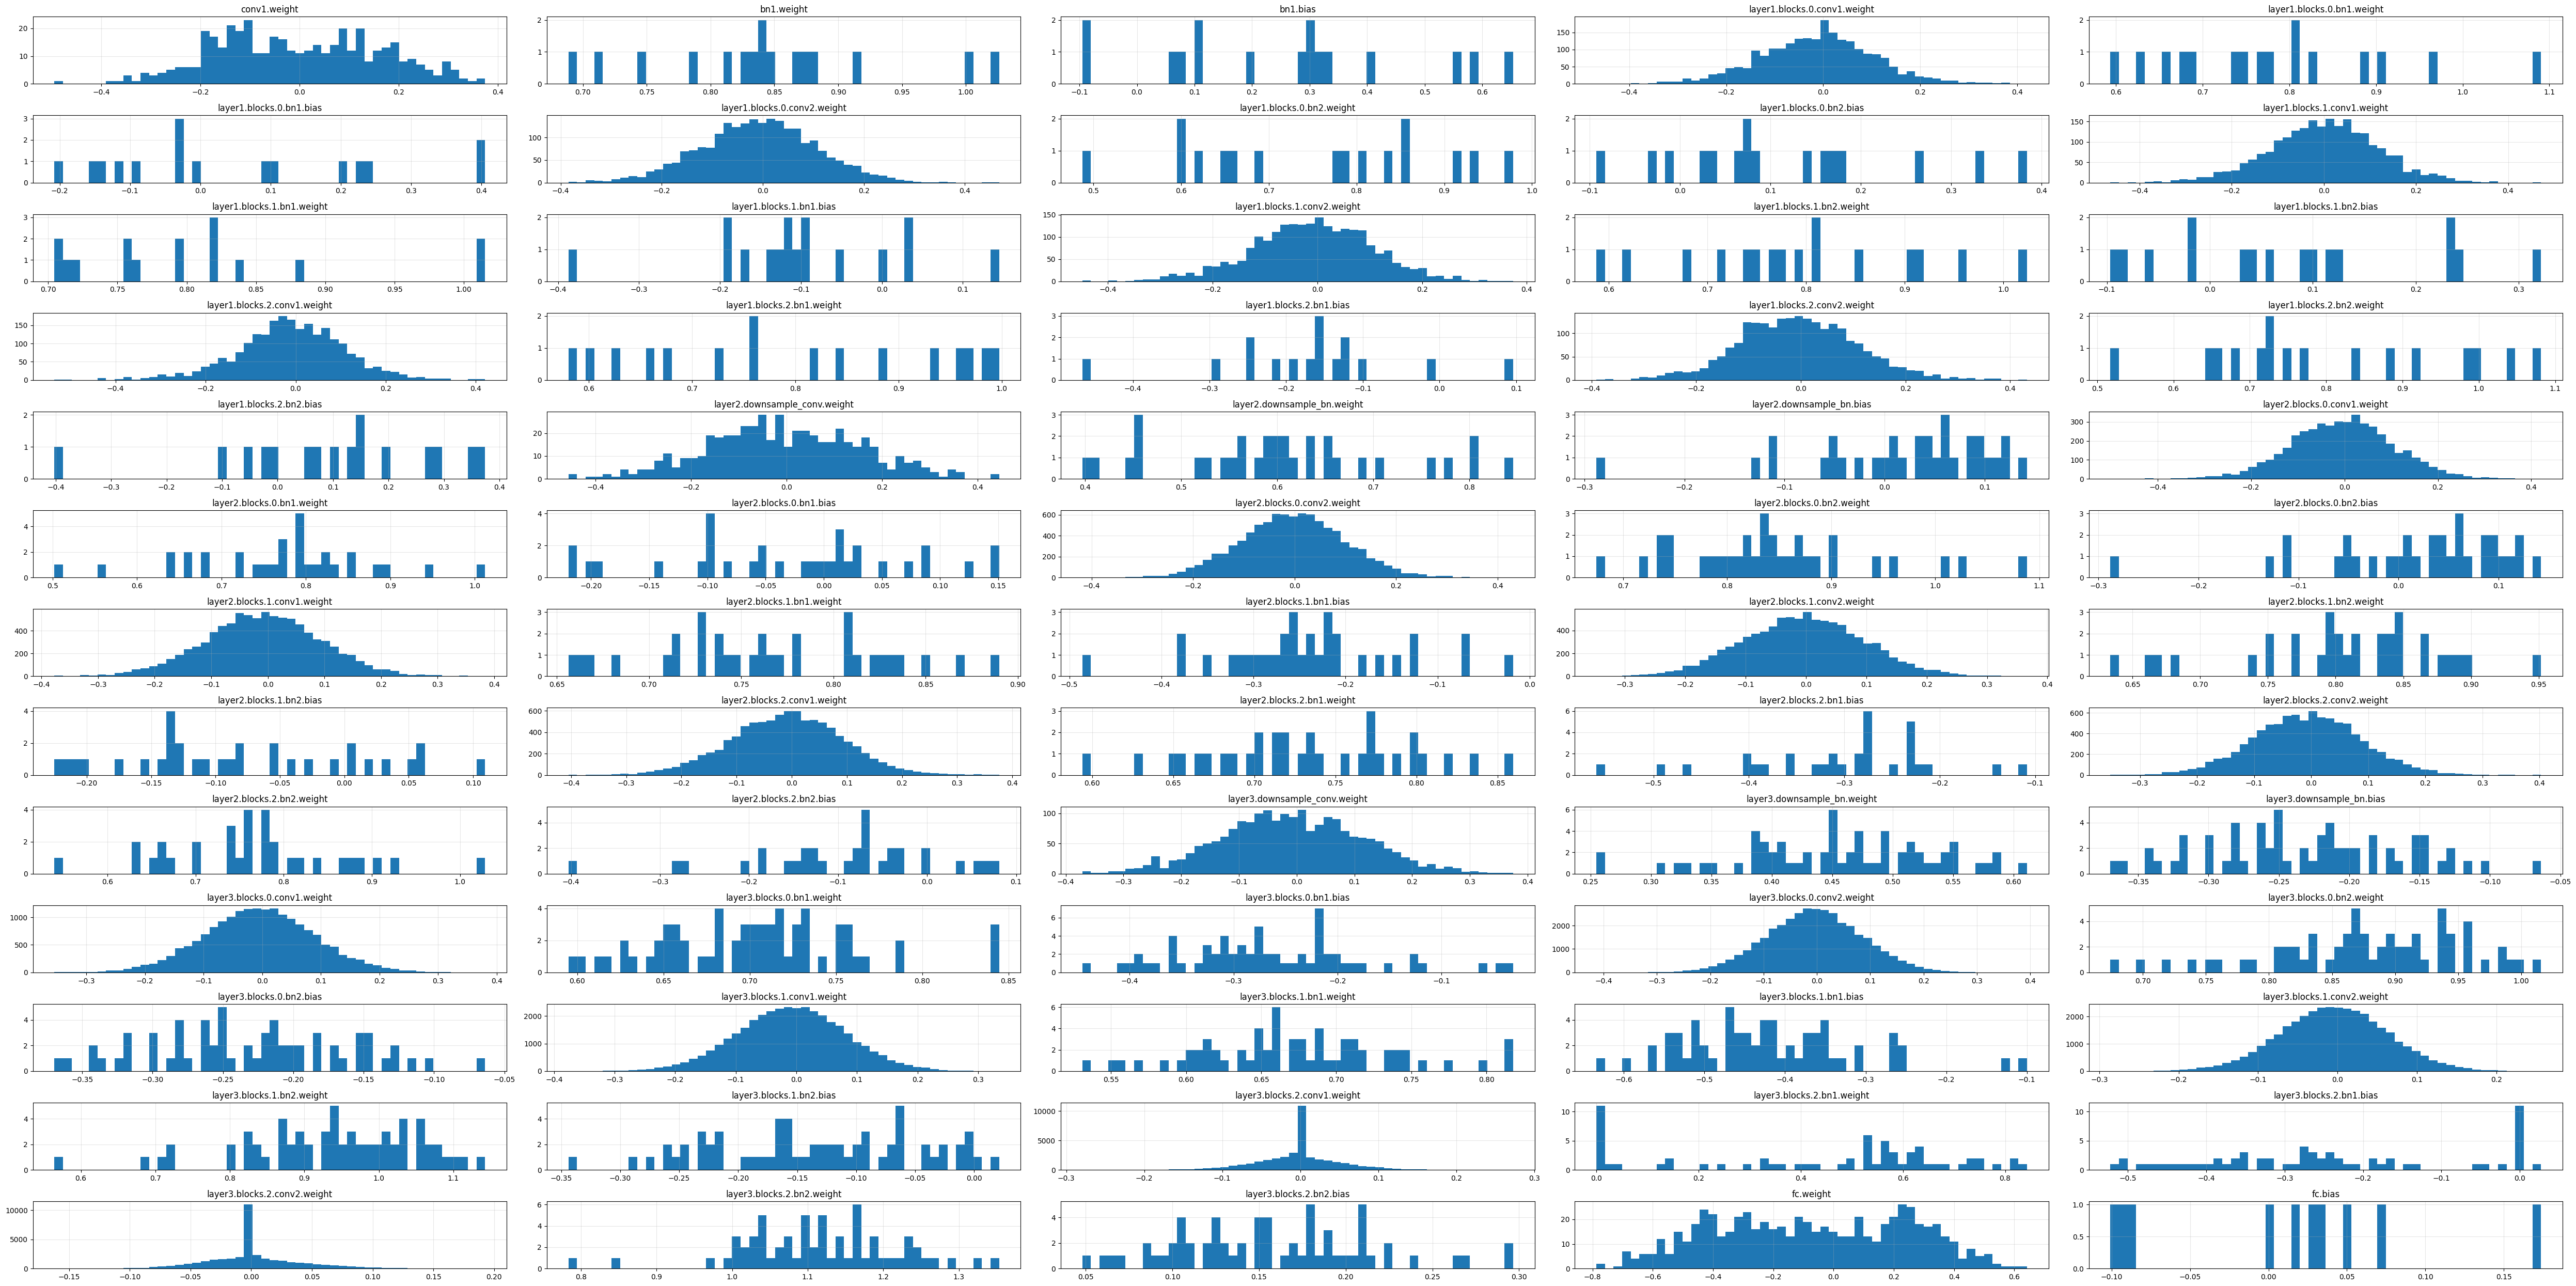

In [8]:
filtered_params = []
for name, tensor in params:
    # Include if name contains: weight, bias, running_mean, running_var, num_batches_tracked
    if any(keyword in name.lower() for keyword in ['weight', 'bias']):
        filtered_params.append((name, tensor))

params = filtered_params
n_params = len(params)

n_cols = 5  # 5 columns
n_rows = (n_params + n_cols - 1) // n_cols  # 13 rows for 65 params

# Create subplots with larger figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(50, 25))
axes = axes.flatten()

# Plot each parameter
for i, (name, tensor) in enumerate(params):
    values = tensor.cpu().numpy().flatten()
    axes[i].hist(values, bins=50)
    axes[i].set_title(name)
    axes[i].grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

In [9]:
# Quantization of weight tensors
quant_acc = []
quant_error = []
bit_array = [16, 14, 12, 10, 8, 6, 4, 3, 2]
activations_dict = {}
quant_dict = {}

for i, bits in enumerate(bit_array):
  activations_dict[bits] = {
    'input_activation': None,
    'prelayer_activation': None,
    'layer1_activation': None,
    'layer2_activation': None,
    'layer3_activation': None
  }
  
  for i, (name, weight_tensor) in enumerate(params):
    quantized_tensor, scale = Quant.symmetric_quantization(weight_tensor, bits=bits)
    fp32_tensor, error = Quant_decode.dequant(scale, quantized_tensor, weight_tensor)
    quant_dict[name] = fp32_tensor

  quant_model = ResNet20().to(device)
  quant_model.load_manual_weights(quant_dict)
  
  print(f"Testing bit {bits} quantization")
  with torch.no_grad():
      number_correct = 0
      samples = 0
      first_batch = True
      for images, labels in testloader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = quant_model(images, save_activations=True)

          _, prediction = torch.max(outputs, 1)
          samples += labels.size(0)
          number_correct += (prediction == labels).sum().item()

          if first_batch:
            for name, activation in quant_model.activations.items():
              activations_dict[bits][name] = activation.cpu().clone()
            first_batch = False

  del quant_model
  torch.cuda.empty_cache() if torch.cuda.is_available() else None
  quant_acc.append((number_correct / samples) * 100.0)
  quant_error.append(error)


Testing bit 16 quantization
Testing bit 14 quantization
Testing bit 12 quantization
Testing bit 10 quantization
Testing bit 8 quantization
Testing bit 6 quantization
Testing bit 4 quantization
Testing bit 3 quantization
Testing bit 2 quantization


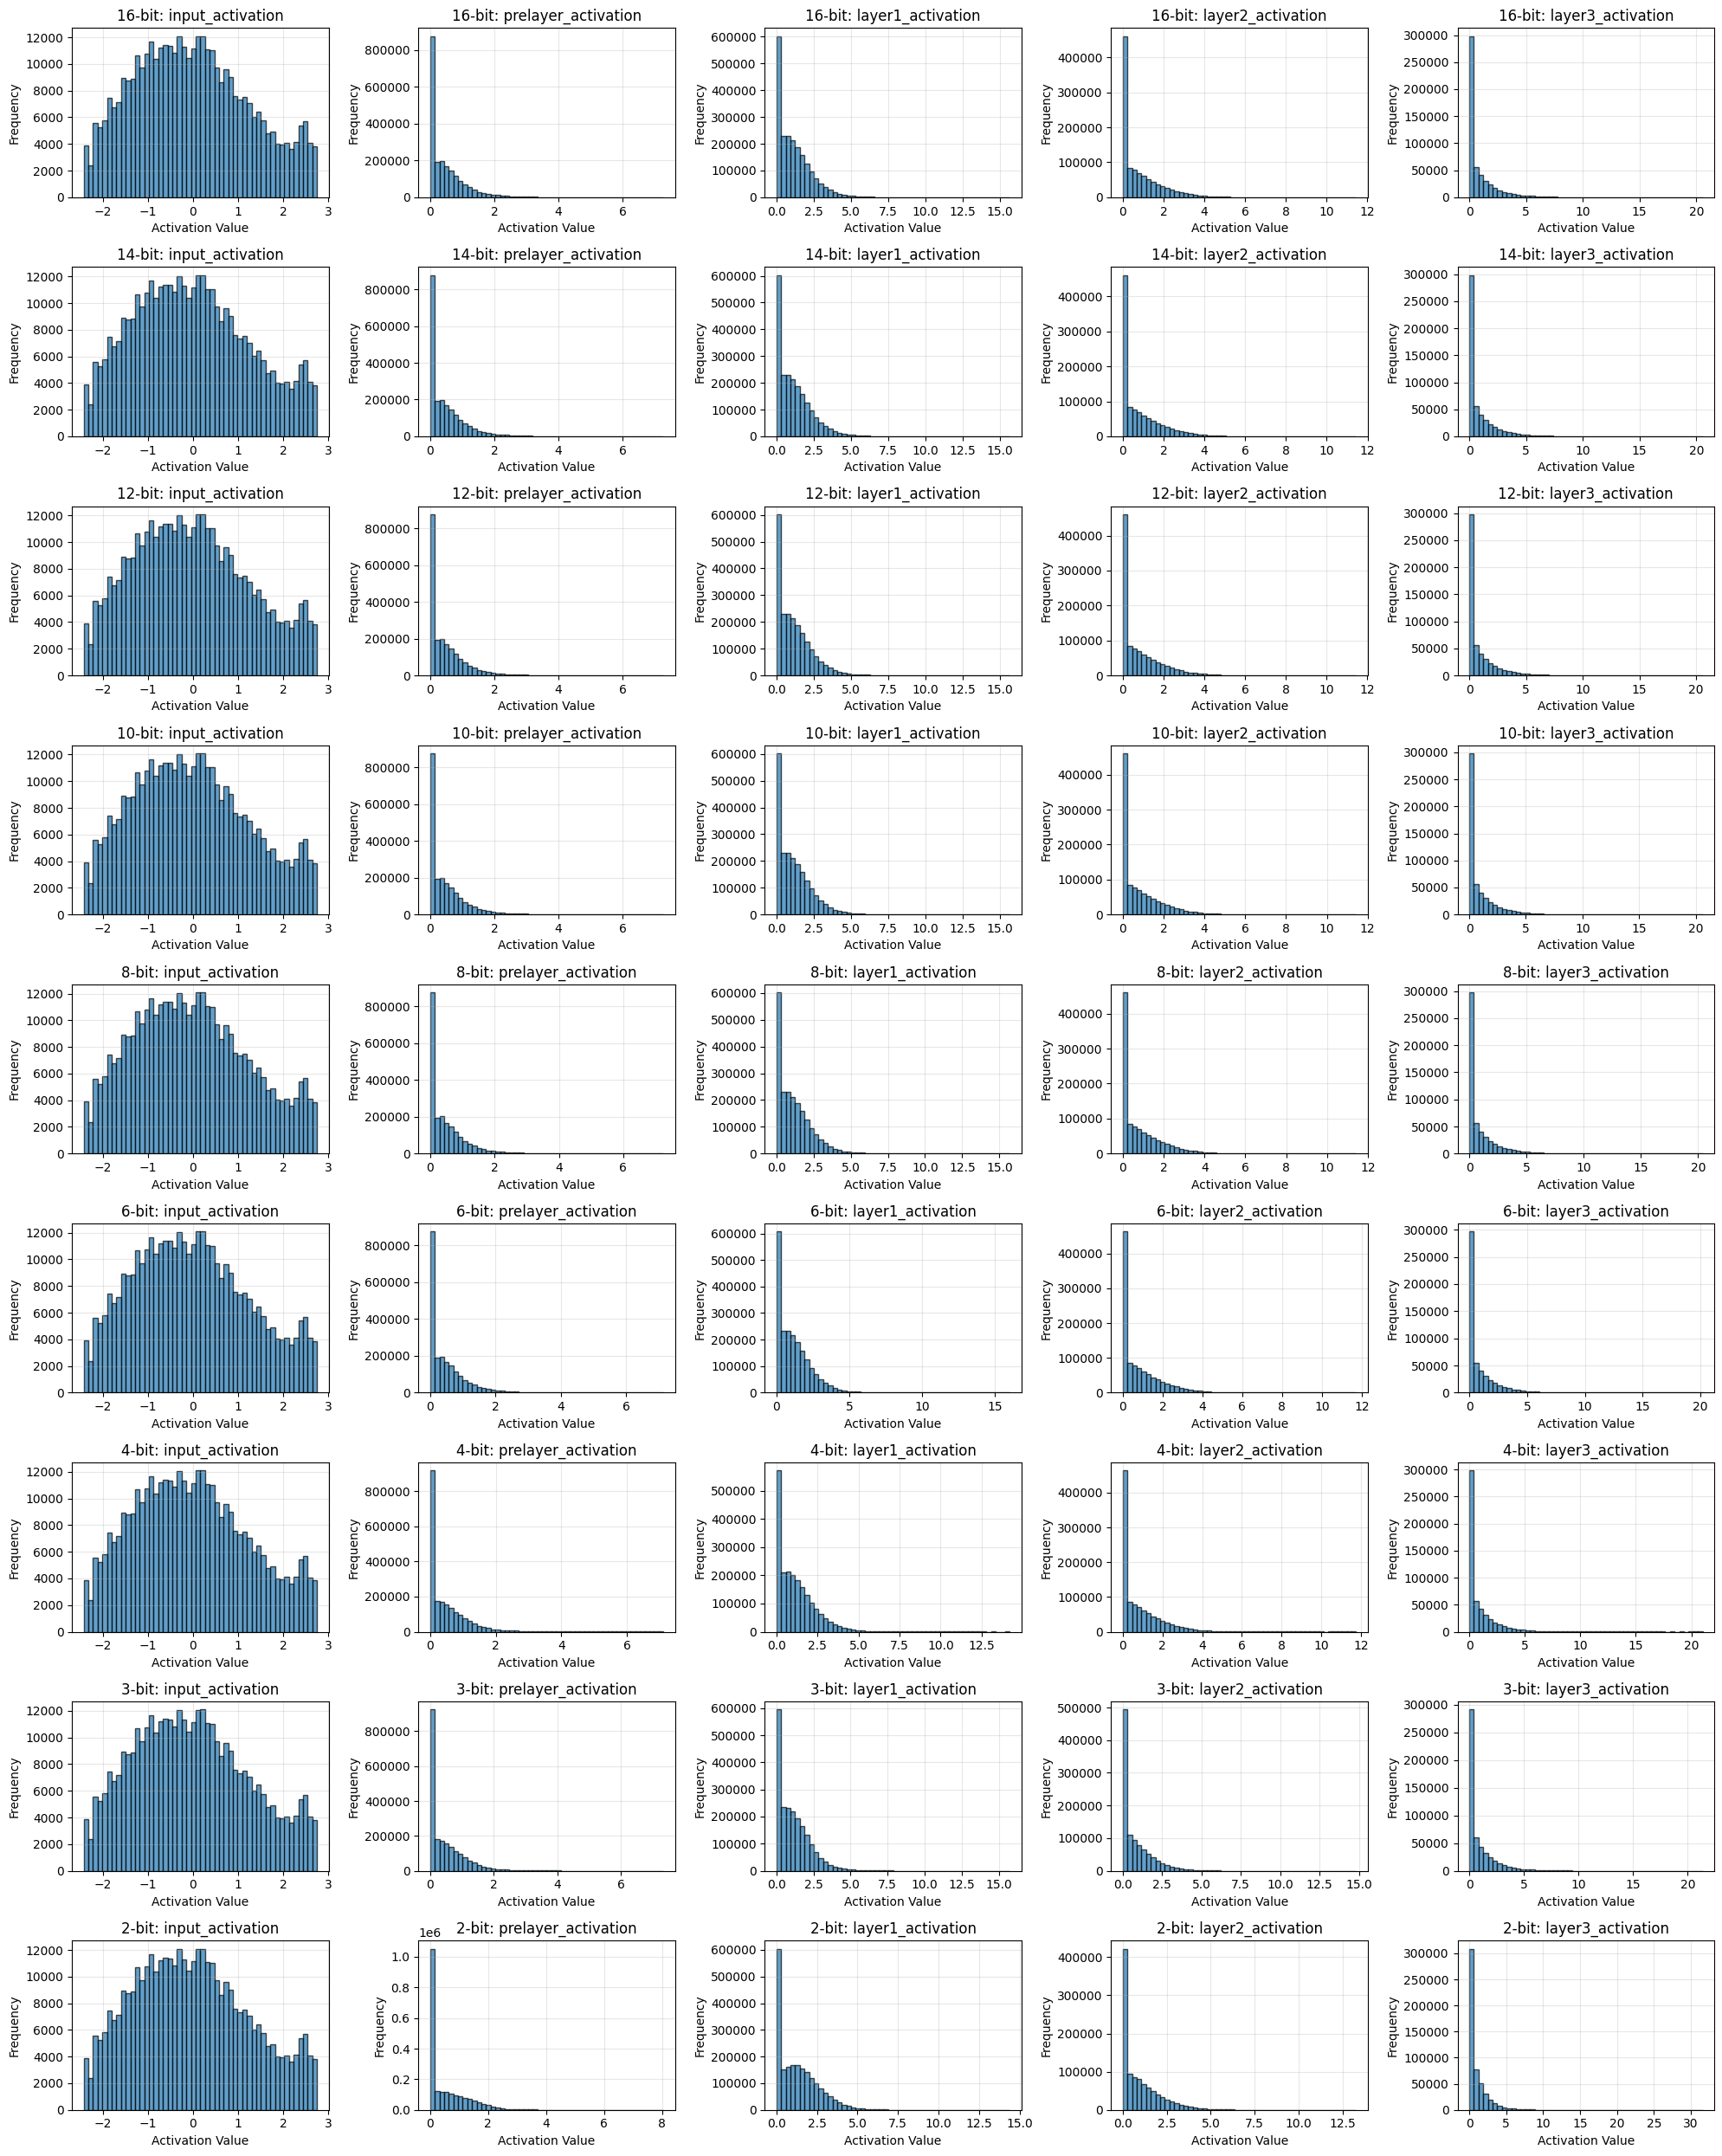

In [11]:
activation_names = list(activations_dict[16].keys())
num_bits = len(bit_array)
num_activations = len(activation_names)

fig, axes = plt.subplots(num_bits, num_activations, figsize=(20, 25))

for i, bits in enumerate(bit_array):
  for j, name in enumerate(activation_names):
    ax = axes[i, j]
  
    act_values = activations_dict[bits][name].cpu().flatten()
    
    ax.hist(act_values, bins=50, edgecolor='black', alpha=0.7)
    ax.set_title(f'{bits}-bit: {name}')
    ax.set_xlabel('Activation Value')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

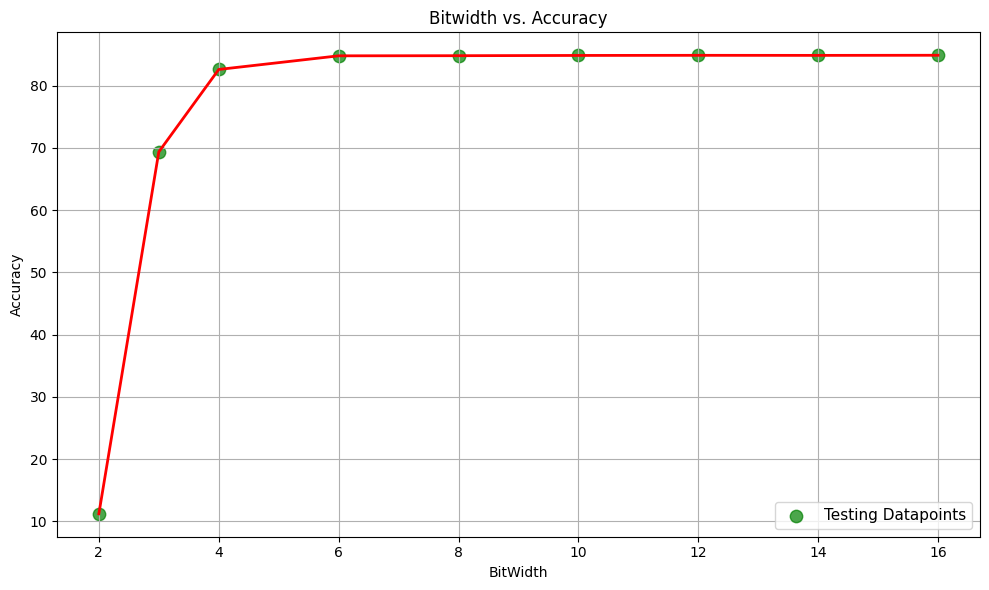

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(bit_array, quant_acc, s=80, c='green', alpha=0.7, label='Testing Datapoints')
ax.plot(bit_array, quant_acc, linewidth=2, c='r')
ax.set_title('Bitwidth vs. Accuracy')
ax.set_xlabel('BitWidth')
ax.set_ylabel('Accuracy')
ax.legend(fontsize=11)
ax.grid(True)

plt.tight_layout()
plt.show()

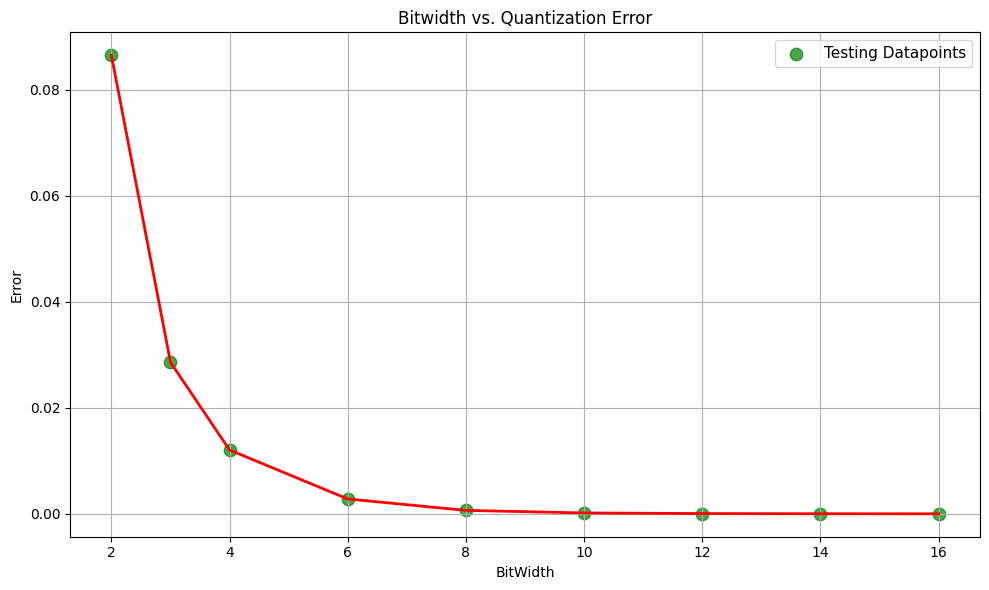

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(bit_array, quant_error, s=80, c='green', alpha=0.7, label='Testing Datapoints')
ax.plot(bit_array, quant_error, linewidth=2, c='r')
ax.set_title('Bitwidth vs. Quantization Error')
ax.set_xlabel('BitWidth')
ax.set_ylabel('Error')
ax.legend(fontsize=11)
ax.grid(True)

plt.tight_layout()
plt.show()